In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, roc_auc_score

In [26]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
bin_cols = ['sex', 'car', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
num_cols = ['decline_app_cnt', 'income']
log_cols = ['income']
target_col = 'default'

In [27]:
df = pd.read_csv('./train-scoring.csv')
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0
3,16222,SCH,F,53,N,N,0,0,2,2,3,10000,N,0
4,101655,GRD,M,48,N,N,0,1,1,2,3,30000,Y,0


In [28]:
# Load dataset
df = pd.read_csv('./train-scoring.csv')

df.drop(columns=["client_id"], inplace=True)
df.drop(columns=["age", "bki_request_cnt", "car_type"], inplace=True)

# Fill up education gaps with most common value
df['education'].fillna('SCH', inplace=True)

# Replace binary colums with 0-1 values
label_encoders = {} 
for col in bin_cols:
    enc = LabelEncoder()
    df[col] = enc.fit_transform(df[col])
    label_encoders[col] = enc

# Replace categorial columns with dummies
df = pd.get_dummies(df, columns=cat_cols)

for col in log_cols:
    df[col] = np.log(df[col])

scalers = {}
for col in num_cols:
    scaler = StandardScaler()
    scalers[col] = scaler
    df[col] = scaler.fit_transform(df[[col]])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sex               73799 non-null  int64  
 1   car               73799 non-null  int64  
 2   decline_app_cnt   73799 non-null  float64
 3   good_work         73799 non-null  int64  
 4   income            73799 non-null  float64
 5   foreign_passport  73799 non-null  int64  
 6   default           73799 non-null  int64  
 7   education_ACD     73799 non-null  uint8  
 8   education_GRD     73799 non-null  uint8  
 9   education_PGR     73799 non-null  uint8  
 10  education_SCH     73799 non-null  uint8  
 11  education_UGR     73799 non-null  uint8  
 12  home_address_1    73799 non-null  uint8  
 13  home_address_2    73799 non-null  uint8  
 14  home_address_3    73799 non-null  uint8  
 15  work_address_1    73799 non-null  uint8  
 16  work_address_2    73799 non-null  uint8 

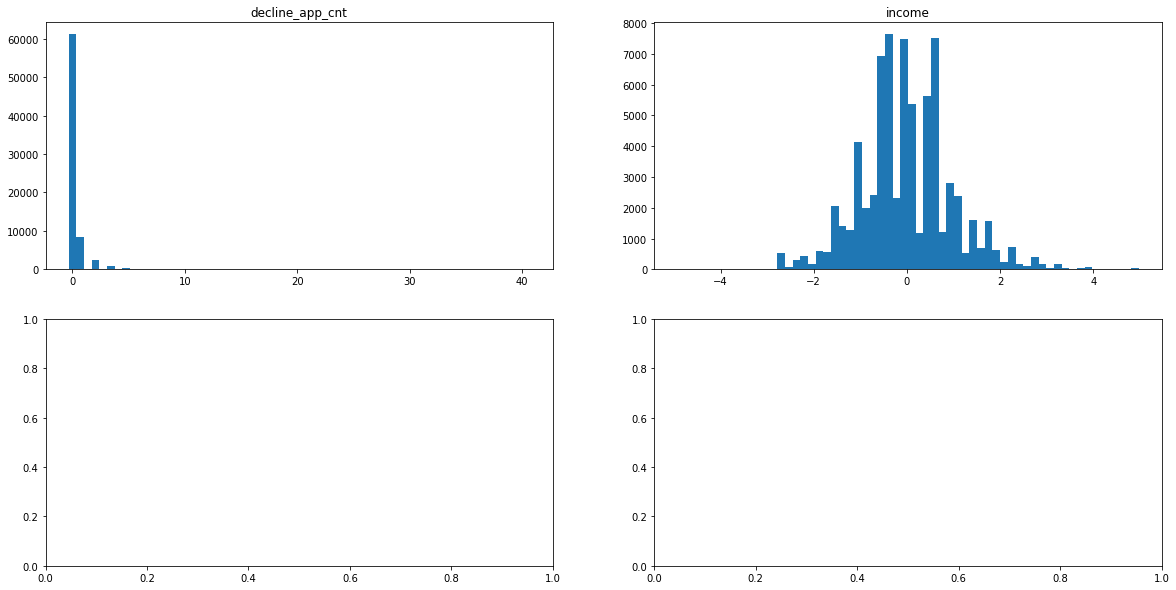

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
for col, ax in zip(num_cols, axs.flat):
    ax.hist(df[col], bins=60)
    ax.set_title(col)

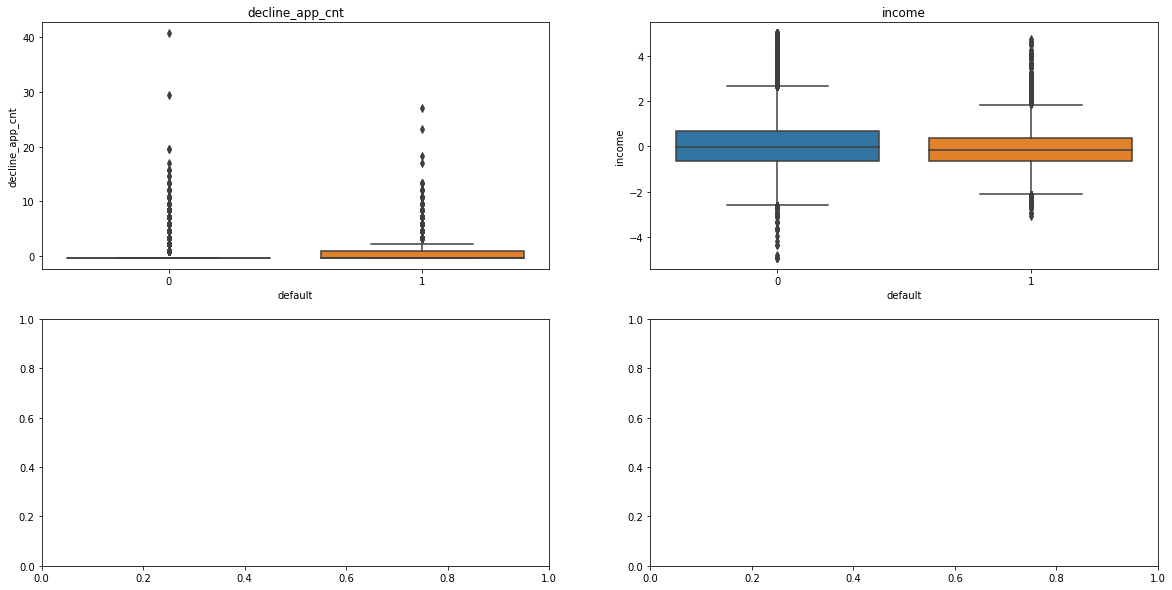

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
for col, ax in zip(num_cols, axs.flat):
    sns.boxplot(x=target_col, y=col, data=df, ax=ax)
    ax.set_title(col)

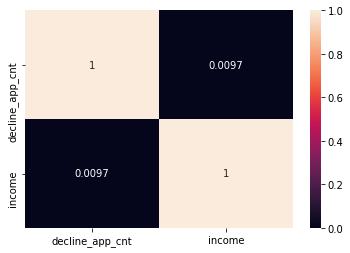

In [31]:
sns.heatmap(df[num_cols].corr().abs(), annot=True, vmin=0, vmax=1)

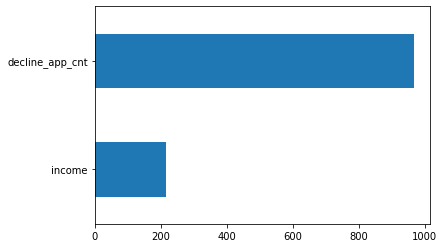

In [32]:
f_vals, p_vals = f_classif(df[num_cols], df[target_col])
pd.Series(f_vals, index=num_cols).sort_values().plot(kind='barh')

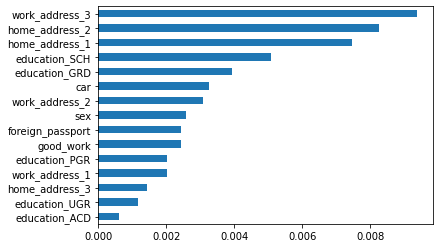

In [8]:
df1 = df.drop(columns=[*num_cols, target_col])
f_vals = mutual_info_classif(df1, df[target_col])
pd.Series(f_vals, index=df1.columns).sort_values().plot(kind='barh')

In [9]:
df = df[['decline_app_cnt', 'home_address_2', 'home_address_3', target_col]]
df_default_1 = df[df[target_col] == 1]
df_default_0 = df[df[target_col] == 0]
df_default_0 = df_default_0[:df_default_1.shape[0]]

df1 = pd.concat([df_default_0, df_default_1])

X = df1.drop(columns=[target_col]).values
y = df1[target_col].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

precision_metric = precision_score(y_test, y_pred)
recall_metric = recall_score(y_test, y_pred)
f1_metric = f1_score(y_test, y_pred)

print("precision_metric", precision_metric)
print("recall_metric", recall_metric)
print("f1_metric", f1_metric)

precision_metric 0.555367709213863
recall_metric 0.7056928034371643
f1_metric 0.6215704824976347


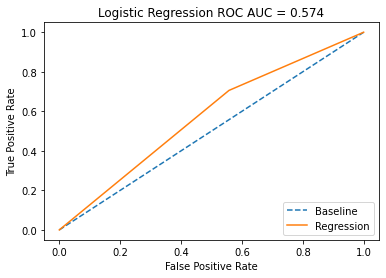

In [13]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [15]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0
